# Predict species-wise volumes from percentages

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

/opt/conda/lib/python3.8/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Read and preprocess data

In [2]:
data_path = Path('../../../andras/ml/AV_leafon/')
#data_path = Path('../../enveco_data/enveco/')
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

In [3]:
trainval_tb, test_tb = preprocessor.preprocess(target_col=['v'], 
                                               path=data_path,
                                               lidar_pref='AV_las',
                                               image_pref='AV_tif',
                                               mask_plot=False,
                                               min_h=1.3,
                                               normalize=True,
                                               log_y=False,
                                               save_path='../../data/')

100%|██████████| 225/225 [00:26<00:00,  8.42it/s]


# Start by predicting total volume

In [4]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())
y_max = trainval_tb.train.y.max()
ensemble = Ensemble(dls, learn_func=tabular_learner,
                    y_range=(0, y_max), 
                    metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()],
                    n_models=10)

ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,54618.339844,22609.644531,150.365021,99.732307,126.860558,84.142548,137.819992,-1.484357,00:00
1,26521.011719,6980.246094,83.547867,55.414627,-5.149375,-3.415416,59.760197,0.233008,00:00
2,16497.716797,4148.106445,64.405792,42.718304,-17.617777,-11.685308,46.805237,0.544204,00:00
3,11072.114258,2220.785645,47.125206,31.256643,1.068695,0.708831,33.243675,0.755979,00:00
4,8000.656250,2891.469727,53.772385,35.665504,-6.772336,-4.491874,36.700008,0.682284,00:00
5,6167.145508,3263.446777,57.126587,37.890236,-18.502285,-12.271974,35.474270,0.641411,00:00
6,4812.136230,2306.922119,48.030430,31.857046,17.511608,11.614889,34.551491,0.746514,00:00
7,3849.503662,2038.046143,45.144726,29.943052,-17.042824,-11.303960,32.094551,0.776059,00:00
8,3092.715576,1881.911377,43.381004,28.773233,1.163147,0.771478,31.556435,0.793215,00:00
9,2516.813477,2178.741699,46.676994,30.959356,12.639338,8.383269,30.916132,0.760599,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,45641.335938,22693.947266,150.645111,99.918083,122.666092,81.360497,137.122910,-1.493621,00:00
1,22194.814453,6899.951172,83.065948,55.094986,-10.317735,-6.843423,60.014755,0.241830,00:00
2,14213.645508,4835.604980,69.538513,46.122669,-2.153900,-1.428613,53.060051,0.468662,00:00
3,9828.045898,2738.470215,52.330391,34.709076,-8.939499,-5.929284,36.257771,0.699096,00:00
4,7140.550781,2858.541016,53.465328,35.461842,-3.292911,-2.184083,36.143028,0.685902,00:00
5,5465.909180,1752.047607,41.857468,27.762720,-6.100666,-4.046376,30.433737,0.807484,00:00
6,4270.494141,2404.605713,49.036777,32.524525,-6.537274,-4.335965,32.900558,0.735781,00:00
7,3438.101562,2209.201904,47.002148,31.175020,8.154004,5.408290,32.269215,0.757252,00:00
8,2783.459473,2610.594727,51.093979,33.889000,-4.097870,-2.717986,32.864143,0.713147,00:00
9,2304.095947,2254.520020,47.481785,31.493149,-3.891336,-2.580999,32.123177,0.752272,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,47312.281250,22492.763672,149.975876,99.474205,125.411713,83.181572,137.369415,-1.471514,00:00
1,22826.943359,5233.532715,72.343163,47.982903,-13.232635,-8.776783,53.948090,0.424937,00:00
2,14429.753906,4452.294922,66.725517,44.256901,5.360840,3.555674,48.695461,0.510780,00:00
3,10008.056641,3696.402344,60.798046,40.325401,-6.693107,-4.439323,42.905491,0.593838,00:00
4,7225.661621,2164.233398,46.521320,30.856102,1.734940,1.150730,30.607592,0.762193,00:00
5,5569.456055,2896.893311,53.822796,35.698936,-21.914316,-14.535065,35.018314,0.681688,00:00
6,4445.863281,2026.788574,45.019875,29.860243,5.167755,3.427606,32.558708,0.777296,00:00
7,3498.802979,1604.133911,40.051640,26.564970,-1.475384,-0.978575,27.603645,0.823737,00:00
8,2913.226074,1878.416748,43.340710,28.746506,0.183425,0.121660,29.606258,0.793599,00:00
9,2538.173096,1813.176392,42.581409,28.242886,4.619898,3.064230,30.254511,0.800767,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,42581.207031,18848.312500,137.289169,91.059509,105.120522,69.723076,122.759087,-1.071061,00:00
1,20833.396484,9692.341797,98.449692,65.298531,12.832688,8.511512,67.955505,-0.064999,00:00
2,13295.216797,3357.897217,57.947365,38.434635,-10.301288,-6.832515,40.107079,0.631033,00:00
3,9276.316406,2929.249268,54.122540,35.897751,-14.486372,-9.608347,38.399548,0.678133,00:00
4,6896.197266,1907.316528,43.672836,28.966797,5.552030,3.682484,32.534458,0.790423,00:00
5,5360.668945,2098.781494,45.812462,30.385941,8.550355,5.671177,32.404747,0.769385,00:00
6,4290.696777,2394.780273,48.936493,32.458012,-11.010363,-7.302821,33.780617,0.736861,00:00
7,3495.453369,2144.479492,46.308525,30.714962,12.640544,8.384068,32.991428,0.764364,00:00
8,2886.850830,1887.442871,43.444714,28.815491,1.425479,0.945475,30.771864,0.792607,00:00
9,2381.165771,1649.556396,40.614731,26.938450,-11.741282,-7.787617,28.555286,0.818746,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,47513.156250,22234.097656,149.111038,98.900581,125.057152,82.946404,136.620560,-1.443092,00:00
1,22865.867188,7234.028320,85.053093,56.412994,-1.039909,-0.689738,61.466599,0.205122,00:00
2,14565.296875,3860.040771,62.129223,41.208328,-5.841942,-3.874773,46.295544,0.575857,00:00
3,10002.266602,2569.999756,50.695168,33.624481,7.442230,4.936193,33.766220,0.717607,00:00
4,7416.984863,3293.412598,57.388264,38.063801,12.932538,8.577739,38.256310,0.638118,00:00
5,5732.601562,3014.630859,54.905655,36.417164,-2.179478,-1.445578,36.698517,0.668751,00:00
6,4668.466309,2658.341553,51.559109,34.197506,16.964479,11.251997,36.666176,0.707900,00:00
7,3858.736572,3766.428223,61.371227,40.705570,-31.728941,-21.044792,42.850258,0.586143,00:00
8,3238.138672,1784.008057,42.237522,28.014797,10.297750,6.830167,30.275908,0.803972,00:00
9,2630.257812,1658.083618,40.719574,27.007992,-10.482825,-6.952922,27.676584,0.817809,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,51995.496094,24690.968750,157.133591,104.221687,128.530594,85.250229,141.466507,-1.713054,00:00
1,25371.191406,9882.498047,99.410759,65.935974,8.650857,5.737837,71.783066,-0.085893,00:00
2,16312.308594,4528.379883,67.293236,44.633450,-13.880272,-9.206341,50.682907,0.502420,00:00
3,11110.324219,2776.180664,52.689472,34.947239,5.065385,3.359708,35.545174,0.694952,00:00
4,7966.858398,2130.833008,46.160946,30.617079,-6.372534,-4.226697,32.818825,0.765863,00:00
5,6071.419922,1804.686523,42.481602,28.176685,-1.982709,-1.315068,32.277271,0.801700,00:00
6,4722.885254,1962.193481,44.296654,29.380554,-4.333243,-2.874102,30.171114,0.784393,00:00
7,3736.591553,2573.691895,50.731567,33.648624,-6.088871,-4.038553,31.087908,0.717202,00:00
8,3129.157715,2361.884521,48.599220,32.234306,-16.871439,-11.190286,31.364264,0.740475,00:00
9,2526.458984,1540.532837,39.249622,26.033020,6.766660,4.488109,28.283194,0.830726,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,55654.375000,24276.001953,155.807587,103.342186,134.947861,89.506599,143.572998,-1.667458,00:00
1,26626.712891,9957.998047,99.789764,66.187355,3.419203,2.267848,67.150620,-0.094189,00:00
2,16615.468750,4384.685547,66.216957,43.919590,12.297582,8.156592,52.976555,0.518209,00:00
3,11392.524414,3122.897949,55.882900,37.065338,-11.749171,-7.792850,39.703201,0.656855,00:00
4,8350.416016,3793.991211,61.595383,40.854248,-13.149953,-8.721943,39.148186,0.583115,00:00
5,6290.635254,2457.854248,49.576748,32.882671,8.510800,5.644941,35.519371,0.729930,00:00
6,4841.671875,1874.869019,43.299759,28.719345,3.281071,2.176229,29.396585,0.793989,00:00
7,3731.992432,1585.082764,39.813103,26.406755,5.803546,3.849307,29.400608,0.825830,00:00
8,2974.306885,1811.565796,42.562492,28.230339,-4.233252,-2.807781,29.157555,0.800944,00:00
9,2443.181152,1744.659668,41.769123,27.704123,-0.510141,-0.338360,28.616127,0.808296,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,34817.343750,17523.990234,132.378204,87.802231,100.037407,66.351608,117.200676,-0.925544,00:00
1,17804.697266,7814.988281,88.402420,58.634495,4.308602,2.857758,64.122047,0.141286,00:00
2,11927.583008,5126.956055,71.602768,47.491825,-21.874388,-14.508581,46.935619,0.436648,00:00
3,8474.347656,2602.528809,51.014984,33.836605,-1.482216,-0.983106,35.180012,0.714033,00:00
4,6235.479004,3196.056152,56.533672,37.496975,18.623549,12.352404,41.794674,0.648816,00:00
5,4789.242676,2549.810059,50.495644,33.492146,13.997931,9.284380,33.374798,0.719826,00:00
6,3828.468262,1976.194702,44.454414,29.485189,-15.730864,-10.433778,31.123657,0.782855,00:00
7,3085.800293,1914.459595,43.754539,29.020987,9.815743,6.510468,30.005894,0.789638,00:00
8,2470.801514,1440.555054,37.954647,25.174103,-0.225591,-0.149628,25.398554,0.841711,00:00
9,2072.564941,1654.711914,40.678150,26.980516,-10.666978,-7.075065,27.848324,0.818180,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,51562.281250,26324.724609,162.248962,107.614540,135.444824,89.836220,148.237793,-1.892572,00:00
1,25296.832031,4485.713379,66.975471,44.422688,-17.587484,-11.665215,52.396755,0.507108,00:00
2,15982.494141,4035.138672,63.522743,42.132603,-6.924882,-4.593053,49.616180,0.556617,00:00
3,10966.722656,3499.719727,59.158428,39.237892,3.128935,2.075323,40.744808,0.615449,00:00
4,7875.231445,2054.687256,45.328659,30.065050,5.169138,3.428524,32.483829,0.774230,00:00
5,5868.104492,2722.961670,52.182007,34.610657,-10.581679,-7.018490,35.071312,0.700800,00:00
6,4657.657227,2518.575195,50.185410,33.286377,-11.355626,-7.531824,34.561302,0.723258,00:00
7,3741.905762,1849.291260,43.003387,28.522772,12.101214,8.026348,30.101505,0.796799,00:00
8,2987.840820,1924.099976,43.864563,29.093964,12.049476,7.992032,29.865385,0.788579,00:00
9,2409.034424,1527.019287,39.077091,25.918585,-3.113482,-2.065073,25.321461,0.832210,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,48220.878906,22925.464844,151.411575,100.426460,120.821022,80.136719,137.091782,-1.519060,00:00
1,23989.894531,8603.319336,92.754082,61.520813,-3.082835,-2.044746,65.615219,0.054664,00:00
2,15186.907227,3436.858643,58.624729,38.883907,-11.392743,-7.556442,43.824089,0.622357,00:00
3,10560.014648,3330.647705,57.711765,38.278370,17.095226,11.338717,39.669983,0.634027,00:00
4,7818.440430,3529.546631,59.409988,39.404743,29.318724,19.446171,42.035599,0.612172,00:00
5,6014.769043,2064.785156,45.439907,30.138838,-1.152408,-0.764355,30.118305,0.773121,00:00
6,4582.189941,1621.787109,40.271420,26.710745,-3.850896,-2.554176,28.042213,0.821797,00:00
7,3640.473877,2632.500000,51.307896,34.030884,20.690481,13.723334,34.399410,0.710740,00:00
8,3061.076660,2222.992432,47.148621,31.272173,-1.919746,-1.273306,32.535561,0.755737,00:00
9,2515.548584,1708.043091,41.328480,27.411858,4.575161,3.034558,27.655186,0.812319,00:00


In [5]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)
test_v_predict = ensemble.get_ensemble_preds(dl=test_dls[0])


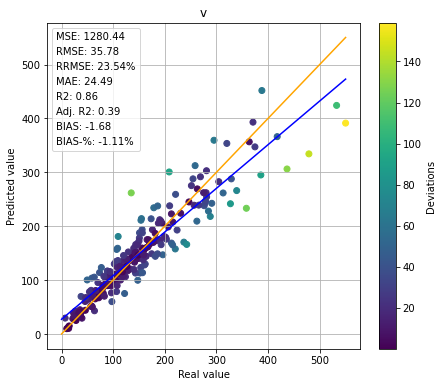

In [6]:
reg_itp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])
reg_itp.plot_results(log_y=False)
plt.show()

# Then predict species-wise volumes

In [7]:
trainval_tb, test_tb = preprocessor.load_las_image(path='../../data/',
                                                  target_col=['v_ma'],
                                                  log_y=False)

In [8]:
sp_dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())
y_max = trainval_tb.train.y.max()
ensemble = Ensemble(sp_dls, learn_func=tabular_learner,
                    y_range=(0, y_max), 
                    metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()],
                    n_models=10)

ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,13222.631836,6847.206543,82.747856,89.564377,63.540649,68.774940,71.713966,-0.473151,00:00
1,7177.386230,2598.662109,50.977074,55.176414,-9.252420,-10.014607,40.268074,0.440908,00:00
2,5001.576660,1903.319702,43.627052,47.220917,-0.169164,-0.183100,33.682667,0.590508,00:00
3,3785.110840,2759.298096,52.529022,56.856201,-4.463655,-4.831357,35.384922,0.406347,00:00
4,3197.555420,2292.501709,47.880077,51.824295,3.120737,3.377814,34.815639,0.506777,00:00
5,2789.493652,1965.308838,44.331802,47.983723,10.760837,11.647282,32.878609,0.577171,00:00
6,2456.156982,1518.599976,38.969215,42.179382,-9.033639,-9.777802,27.126432,0.673279,00:00
7,2093.594482,1412.340576,37.581120,40.676941,-8.602244,-9.310871,27.350904,0.696140,00:00
8,1836.011108,1583.058105,39.787663,43.065250,-6.153000,-6.659865,27.879074,0.659411,00:00
9,1629.404663,1577.770508,39.721161,42.993271,2.405736,2.603914,28.002674,0.660549,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,23610.705078,11511.027344,107.289459,116.127647,91.607559,99.153915,95.621574,-1.476554,00:00
1,12055.301758,3154.065918,56.161072,60.787453,-14.154440,-15.320439,43.900063,0.321415,00:00
2,8207.360352,3965.366943,62.971165,68.158539,19.299911,20.889780,47.779213,0.146866,00:00
3,5997.038574,2337.844727,48.351265,52.334297,7.841391,8.487341,36.431358,0.497022,00:00
4,4612.415527,1806.094971,42.498177,45.999046,-0.956845,-1.035667,31.184555,0.611425,00:00
5,3638.845215,1529.462524,39.108345,42.329971,-7.824893,-8.469484,28.021725,0.670942,00:00
6,3031.235107,1707.223145,41.318562,44.722260,4.254078,4.604517,31.018269,0.632697,00:00
7,2498.456787,1351.794556,36.766758,39.795494,2.483203,2.687762,27.277332,0.709166,00:00
8,2212.226074,1784.548340,42.243912,45.723839,8.995064,9.736050,31.379705,0.616061,00:00
9,1924.178345,1421.665649,37.704979,40.811001,6.789033,7.348293,27.705868,0.694134,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,16646.570312,8233.258789,90.737305,98.211967,72.303375,78.259506,79.276825,-0.771354,00:00
1,8674.102539,2735.579102,52.302765,56.611313,-14.504185,-15.698996,40.617603,0.411450,00:00
2,6002.541504,2016.062256,44.900581,48.599358,0.571061,0.618103,34.482964,0.566252,00:00
3,4438.654785,2904.172119,53.890369,58.329697,8.473384,9.171395,42.071224,0.375178,00:00
4,3699.628174,3011.434814,54.876537,59.397102,18.696337,20.236485,41.462761,0.352101,00:00
5,3073.928955,1923.766846,43.860767,47.473888,-7.561811,-8.184731,31.476597,0.586109,00:00
6,2630.358154,1577.712769,39.720432,42.992481,3.854419,4.171934,29.318590,0.660561,00:00
7,2205.480469,1474.551758,38.399891,41.563160,-8.968672,-9.707484,27.304253,0.682756,00:00
8,1888.361084,1398.702515,37.399231,40.480068,-2.124756,-2.299787,27.031931,0.699074,00:00
9,1637.146362,1309.720459,36.190060,39.171288,0.852331,0.922543,26.592974,0.718219,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21921.980469,10603.048828,102.971107,111.453560,88.101524,95.359062,92.030319,-1.281206,00:00
1,11369.302734,3047.237305,55.201786,59.749146,-9.156446,-9.910726,44.466190,0.344398,00:00
2,7596.404297,2249.379883,47.427628,51.334572,2.784935,3.014350,36.551956,0.516054,00:00
3,5544.313477,1652.792358,40.654549,44.003548,6.917815,7.487684,28.634642,0.644408,00:00
4,4320.659180,1668.727539,40.850063,44.215168,-1.406974,-1.522877,30.457886,0.640980,00:00
5,3456.718262,1460.959595,38.222500,41.371155,-6.264542,-6.780596,27.767477,0.685680,00:00
6,2851.646973,1495.438232,38.670898,41.856491,0.029935,0.032401,27.644835,0.678262,00:00
7,2476.451172,1829.126099,42.768284,46.291405,7.870066,8.518378,31.239386,0.606470,00:00
8,2134.346680,1374.241577,37.070763,40.124542,1.095316,1.185545,26.604191,0.704337,00:00
9,1815.491577,1568.707031,39.606903,42.869602,-5.663022,-6.129525,28.859901,0.662499,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,15827.349609,8003.401855,89.461739,96.831329,71.567520,77.463036,77.635193,-0.721902,00:00
1,8615.152344,3897.625732,62.430969,67.573845,-3.313438,-3.586389,48.949669,0.161440,00:00
2,6035.850586,2357.778320,48.556961,52.556938,4.803259,5.198937,35.233959,0.492733,00:00
3,4606.598633,1883.069702,43.394352,46.969048,0.951664,1.030059,32.944008,0.594865,00:00
4,3651.406250,1595.978638,39.949703,43.240639,-9.777546,-10.582991,27.477945,0.656631,00:00
5,3048.395752,1749.626709,41.828537,45.274246,3.735739,4.043478,30.846914,0.623574,00:00
6,2595.347900,1607.792969,40.097294,43.400391,1.549268,1.676892,30.303469,0.654089,00:00
7,2244.984619,1473.933594,38.391842,41.554443,-1.536705,-1.663294,28.771719,0.682889,00:00
8,1982.032715,1382.065552,37.176144,40.238602,-6.618176,-7.163362,26.826485,0.702654,00:00
9,1785.110840,1964.282227,44.320225,47.971191,3.569249,3.863273,32.482590,0.577392,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,17903.541016,9234.251953,96.095009,104.011024,79.632889,86.192810,85.035004,-0.986714,00:00
1,9398.958984,2623.598389,51.221073,55.440510,-14.135672,-15.300125,40.870625,0.435543,00:00
2,6446.332520,2381.824951,48.803944,52.824265,-0.618137,-0.669058,37.206223,0.487559,00:00
3,4844.697754,1517.595337,38.956326,42.165432,0.240239,0.260029,29.491594,0.673495,00:00
4,3768.542480,1856.888672,43.091633,46.641392,-2.654135,-2.872775,31.678118,0.600497,00:00
5,3062.917236,1388.618652,37.264172,40.333881,-2.817076,-3.049138,25.963392,0.701244,00:00
6,2530.398682,2367.764893,48.659683,52.668118,5.830307,6.310590,31.780542,0.490584,00:00
7,2200.468506,1644.135742,40.547939,43.888157,-5.944891,-6.434614,29.010332,0.646270,00:00
8,1928.935059,1508.282227,38.836609,42.035851,-7.830102,-8.475122,27.354528,0.675499,00:00
9,1692.810791,1806.917114,42.507851,46.009521,9.096548,9.845894,30.298307,0.611249,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,17315.343750,9333.837891,96.611786,104.570374,80.415222,87.039589,86.365730,-1.008140,00:00
1,9295.668945,3791.396484,61.574314,66.646622,-2.970916,-3.215651,49.034485,0.184295,00:00
2,6358.390625,2125.386963,46.101917,49.899654,-1.485757,-1.608150,32.952744,0.542731,00:00
3,4845.664551,1623.557739,40.293396,43.612644,0.887005,0.960074,29.425154,0.650698,00:00
4,3753.986084,2046.109619,45.233940,48.960175,9.510510,10.293958,34.715771,0.559787,00:00
5,3074.855957,1905.915649,43.656792,47.253109,-7.908314,-8.559776,30.754107,0.589949,00:00
6,2606.781006,1539.796509,39.240242,42.472736,-3.915013,-4.237520,29.477297,0.668719,00:00
7,2287.805176,1377.912598,37.120247,40.178101,-4.986791,-5.397588,27.144878,0.703547,00:00
8,1960.893677,1872.085449,43.267601,46.831856,-7.555588,-8.177995,30.608307,0.597228,00:00
9,1741.668335,1215.776611,34.867989,37.740307,-2.308268,-2.498416,25.226521,0.738430,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21087.685547,10742.475586,103.645912,112.183952,87.319344,94.512451,92.026230,-1.311203,00:00
1,11079.745117,3712.643555,60.931465,65.950813,-5.391173,-5.835282,46.623112,0.201239,00:00
2,7434.723145,2713.785156,52.094002,56.385349,0.293570,0.317753,38.906677,0.416139,00:00
3,5396.602539,2615.403809,51.141018,55.353863,3.176407,3.438070,36.061638,0.437306,00:00
4,4129.414062,1515.622314,38.930996,42.138012,-1.118281,-1.210402,28.151527,0.673920,00:00
5,3284.642334,1623.600952,40.293934,43.613228,7.734362,8.371495,30.022654,0.650688,00:00
6,2817.785400,1737.818481,41.687153,45.121212,-11.964831,-12.950459,28.611496,0.626115,00:00
7,2424.394531,1648.419556,40.600735,43.945301,2.313796,2.504400,30.117201,0.645349,00:00
8,2072.876709,1382.986084,37.188522,40.251999,-1.304526,-1.411989,26.929754,0.702456,00:00
9,1786.800903,1640.696411,40.505512,43.842236,-10.640794,-11.517350,28.273853,0.647010,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,23463.181641,11023.236328,104.991608,113.640503,85.707008,92.767296,92.884377,-1.371608,00:00
1,12148.143555,3984.658691,63.124149,68.324127,-3.129498,-3.387296,49.693829,0.142716,00:00
2,8104.316895,2976.207520,54.554630,59.048676,13.293026,14.388065,42.483925,0.359680,00:00
3,5924.696289,1722.597534,41.504189,44.923176,-3.989686,-4.318345,30.918266,0.629390,00:00
4,4557.523438,2792.086914,52.840202,57.193016,19.994957,21.642082,39.668423,0.399293,00:00
5,3685.457031,1655.740356,40.690788,44.042770,-1.836735,-1.988039,29.168831,0.643774,00:00
6,2985.539795,1654.570557,40.676411,44.027214,-13.552646,-14.669071,28.040354,0.644025,00:00
7,2546.379639,1441.321167,37.964737,41.092155,-3.587495,-3.883022,26.701021,0.689905,00:00
8,2136.719238,1654.825806,40.679550,44.030609,-0.130435,-0.141179,29.023205,0.643970,00:00
9,1890.506714,1584.726196,39.808624,43.087940,0.161993,0.175338,27.340614,0.659052,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,17433.226562,8493.059570,92.157799,99.749481,74.759003,80.917427,80.497314,-0.827250,00:00
1,9230.252930,3464.350830,58.858738,63.707344,-3.179098,-3.440982,46.404259,0.254658,00:00
2,6359.116211,3199.284668,56.562222,61.221649,9.930984,10.749067,42.904797,0.311686,00:00
3,4733.905273,1644.885132,40.557182,43.898163,-0.980838,-1.061637,29.175987,0.646109,00:00
4,3801.140869,1892.845337,43.506844,47.090809,8.360307,9.049004,33.560158,0.592761,00:00
5,3064.178467,1598.130127,39.976620,43.269775,5.038402,5.453451,28.704853,0.656168,00:00
6,2558.465820,1710.206299,41.354641,44.761311,6.358386,6.882171,29.724497,0.632056,00:00
7,2247.220947,1781.828369,42.211708,45.688980,-15.060041,-16.300642,31.317148,0.616646,00:00
8,1958.365356,1930.176392,43.933773,47.552906,7.056306,7.637583,31.268118,0.584730,00:00
9,1670.276245,1812.253296,42.570568,46.077404,-0.253542,-0.274428,28.649555,0.610101,00:00


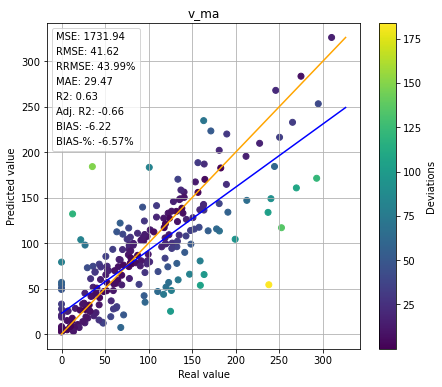

In [9]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)
test_ma_predict = ensemble.get_ensemble_preds(dl=test_dls[0])
reg_itp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])
reg_itp.plot_results(log_y=False)
plt.show()

In [10]:
trainval_tb, test_tb= preprocessor.load_las_image(path='../../data/',
                                                  target_col=['v_ku'],
                                                  log_y=False)

In [11]:
sp_dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())
y_max = trainval_tb.train.y.max()
ensemble = Ensemble(sp_dls, learn_func=tabular_learner,
                    y_range=(0, y_max), 
                    metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()],
                    n_models=10)

ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,18918.089844,11862.646484,108.915779,297.321625,88.536179,241.688782,101.792671,-1.038437,00:00
1,9487.606445,2604.829102,51.037529,139.323807,-0.520448,-1.420736,24.564466,0.552395,00:00
2,6161.789551,2802.378906,52.937500,144.510406,-7.411011,-20.230804,24.945833,0.518449,00:00
3,4350.118652,2413.373535,49.126099,134.105927,-1.261480,-3.443626,23.939390,0.585294,00:00
4,3390.005859,2492.787109,49.927818,136.294479,3.438945,9.387738,25.880047,0.571648,00:00
5,2765.692871,2076.138672,45.564663,124.383820,-3.352148,-9.150795,23.158430,0.643243,00:00
6,2337.270508,2044.161865,45.212410,123.422218,-1.713036,-4.676298,22.304140,0.648738,00:00
7,1955.378906,2250.075928,47.434967,129.489426,-3.433495,-9.372860,22.288280,0.613355,00:00
8,1676.275879,2548.290283,50.480595,137.803467,-6.424458,-17.537682,22.869040,0.562110,00:00
9,1439.664673,2392.921875,48.917500,133.536499,-5.425150,-14.809741,22.769545,0.588808,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,22843.488281,13933.510742,118.040291,322.230011,100.387878,274.041901,111.370506,-1.394287,00:00
1,11731.683594,3400.719482,58.315689,159.191956,-0.696751,-1.902013,28.433889,0.415632,00:00
2,7577.891602,2838.162109,53.274403,145.430099,1.696505,4.631170,25.670507,0.512300,00:00
3,5372.617676,1903.016357,43.623577,119.084976,-0.970667,-2.649756,22.333967,0.672992,00:00
4,4032.850830,3283.490723,57.301750,156.424072,-6.145172,-16.775278,26.489096,0.435776,00:00
5,3110.209229,2237.135498,47.298363,129.116516,5.240875,14.306701,24.156332,0.615578,00:00
6,2493.713379,2819.977051,53.103451,144.963425,2.407523,6.572129,26.162966,0.515425,00:00
7,2066.757324,2476.739746,49.766853,135.855072,9.350036,25.524014,24.752247,0.574405,00:00
8,1761.152588,2131.666748,46.169975,126.036217,6.935350,18.932331,23.091875,0.633702,00:00
9,1508.251709,1923.484863,43.857552,119.723686,-2.743803,-7.490119,20.995207,0.669475,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,24042.000000,13238.475586,115.058571,314.090424,88.849792,242.544891,106.241005,-1.274855,00:00
1,12257.560547,3304.927246,57.488491,156.933838,4.027725,10.995008,29.180241,0.432093,00:00
2,7690.757324,2173.713135,46.623096,127.273155,-2.288656,-6.247643,23.002853,0.626476,00:00
3,5466.479004,3226.349365,56.800964,155.057007,-15.046844,-41.075336,26.192459,0.445595,00:00
4,4257.111328,1816.449829,42.619827,116.344917,-4.187572,-11.431362,21.799448,0.687867,00:00
5,3383.748047,3716.981201,60.967045,166.429718,-13.245345,-36.157551,26.468573,0.361287,00:00
6,2775.818359,2192.152100,46.820423,127.811829,-4.611049,-12.587383,23.015278,0.623308,00:00
7,2354.822021,2122.948730,46.075466,125.778221,2.009027,5.484302,23.961460,0.635200,00:00
8,1975.587769,1809.534424,42.538624,116.123238,0.833820,2.276189,21.650780,0.689056,00:00
9,1652.485352,2274.832031,47.695198,130.199814,-1.743519,-4.759513,23.606384,0.609101,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,28264.708984,17156.505859,130.982849,357.561005,111.835136,305.290985,124.117729,-1.948116,00:00
1,14746.246094,2900.939209,53.860367,147.029694,-5.469254,-14.930140,27.850260,0.501512,00:00
2,9081.512695,2395.387207,48.942692,133.605270,-5.970503,-16.298464,23.018665,0.588385,00:00
3,6279.579102,2316.580811,48.130871,131.389130,-1.252564,-3.419287,23.832964,0.601927,00:00
4,4711.467285,3948.728271,62.838902,171.539551,-18.441078,-50.341019,27.162659,0.321464,00:00
5,3771.666992,2543.180176,50.429955,137.665237,-7.656909,-20.902065,24.726080,0.562989,00:00
6,3018.409668,2036.512085,45.127731,123.191055,2.548129,6.955961,23.012642,0.650053,00:00
7,2395.518555,1924.911621,43.873814,119.768082,-6.236496,-17.024580,21.265858,0.669230,00:00
8,1997.128418,1932.482178,43.960007,120.003380,-2.881506,-7.866024,22.863543,0.667929,00:00
9,1696.065674,2134.428223,46.199875,126.117836,6.819587,18.616320,23.073479,0.633227,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21186.857422,13625.032227,116.726303,318.643036,93.883118,256.285004,109.499016,-1.341279,00:00
1,10957.816406,2924.459229,54.078270,147.624512,0.680317,1.857149,27.637342,0.497471,00:00
2,7056.889160,4343.787598,65.907410,179.916077,13.365358,36.485165,31.225098,0.253578,00:00
3,5264.300293,2249.168945,47.425404,129.463318,-6.242601,-17.041245,23.219717,0.613510,00:00
4,3906.239990,2498.068359,49.980682,136.438797,5.574568,15.217628,25.293629,0.570740,00:00
5,3090.406006,4235.645508,65.081841,177.662415,-19.828293,-54.127884,28.653807,0.272161,00:00
6,2606.861328,2317.510498,48.140530,131.415497,1.981968,5.410436,24.321802,0.601767,00:00
7,2162.202881,2213.521973,47.048080,128.433289,-6.930385,-18.918777,22.221935,0.619636,00:00
8,1779.294434,2322.826172,48.195709,131.566116,4.944673,13.498120,23.363476,0.600853,00:00
9,1516.680176,2375.430176,48.738384,133.047531,6.689591,18.261450,24.577599,0.591814,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21935.117188,14216.630859,119.233513,325.487305,99.291153,271.048035,112.124748,-1.442938,00:00
1,11419.163086,4458.173340,66.769554,182.269577,11.661284,31.833330,31.790764,0.233923,00:00
2,7365.464355,2936.193848,54.186657,147.920395,-0.399081,-1.089424,25.491858,0.495454,00:00
3,5263.005371,2769.604980,52.627037,143.662888,1.795995,4.902761,25.780397,0.524080,00:00
4,4024.596191,2870.115723,53.573456,146.246460,-11.631212,-31.751240,24.820925,0.506809,00:00
5,3223.730225,1881.157593,43.372314,118.399071,-3.537224,-9.656021,22.423172,0.676748,00:00
6,2604.610596,1671.148315,40.879681,111.594604,-4.916971,-13.422499,20.725267,0.712836,00:00
7,2191.564697,1876.921265,43.323448,118.265678,-4.040349,-11.029469,21.745796,0.677476,00:00
8,1838.627686,1882.788086,43.391106,118.450371,1.654629,4.516857,21.807108,0.676468,00:00
9,1585.635254,1569.255615,39.613827,108.139038,-0.913789,-2.494490,20.009304,0.730344,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21160.417969,14064.569336,118.594131,323.741882,97.239220,265.446594,112.573860,-1.416808,00:00
1,11132.203125,2690.719238,51.872147,141.602173,0.445394,1.215849,25.976549,0.537636,00:00
2,7064.406738,4164.559082,64.533386,176.165207,14.035547,38.314667,31.068117,0.284376,00:00
3,5007.992188,3145.180664,56.081913,153.094131,-13.475899,-36.786922,24.935511,0.459543,00:00
4,3924.698730,2209.502197,47.005341,128.316620,-6.267108,-17.108145,23.155338,0.620327,00:00
5,3028.254395,1984.450806,44.547176,121.606239,-7.659021,-20.907831,22.544542,0.658999,00:00
6,2426.862305,2841.500000,53.305721,145.515594,-4.795630,-13.091259,25.438461,0.511726,00:00
7,2087.322998,2368.368652,48.665886,132.849625,0.877451,2.395293,23.355364,0.593028,00:00
8,1810.866455,2593.522949,50.926643,139.021118,-4.556128,-12.437457,24.022190,0.554338,00:00
9,1594.091797,1876.663086,43.320469,118.257545,-2.273659,-6.206703,21.605440,0.677521,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,15836.058594,10278.331055,101.382103,276.755981,76.120346,207.795654,93.309013,-0.766194,00:00
1,8326.303711,3208.566162,56.644207,154.629089,1.859136,5.075127,27.349157,0.448651,00:00
2,5361.632812,3263.666504,57.128506,155.951141,-6.170252,-16.843742,27.279438,0.439183,00:00
3,4012.212891,2492.546631,49.925407,136.287903,-2.653206,-7.242805,24.194649,0.571689,00:00
4,3060.210938,1758.080322,41.929470,114.460350,-0.746247,-2.037129,21.443970,0.697897,00:00
5,2400.897217,1997.091675,44.688831,121.992943,0.553057,1.509752,23.208784,0.656827,00:00
6,1989.981079,2146.111328,46.326141,126.462517,5.118392,13.972343,23.264681,0.631220,00:00
7,1696.376343,2483.072021,49.830437,136.028656,-1.906074,-5.203260,23.720455,0.573317,00:00
8,1473.603882,2807.990234,52.990479,144.655029,6.499974,17.743828,25.474642,0.517484,00:00
9,1287.076050,2111.937012,45.955818,125.451599,-6.318658,-17.248867,21.440573,0.637092,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,18187.548828,11632.490234,107.854019,294.423187,84.525848,230.741257,99.994400,-0.998888,00:00
1,9319.225586,3405.185791,58.353970,159.296448,2.867684,7.828291,28.220686,0.414864,00:00
2,5976.730469,3710.991455,60.917908,166.295578,7.051541,19.249514,29.131975,0.362316,00:00
3,4373.243652,3371.485352,58.064495,158.506241,3.163504,8.635830,28.246271,0.420655,00:00
4,3408.445312,2722.056885,52.173336,142.424362,-15.653790,-42.732197,24.254066,0.532251,00:00
5,2758.308105,2784.979980,52.772911,144.061111,3.100139,8.462853,26.338446,0.521439,00:00
6,2322.182861,2566.621338,50.661835,138.298218,-10.680549,-29.156088,22.813969,0.558960,00:00
7,1937.142212,2624.836670,51.233162,139.857849,4.509705,12.310732,26.017843,0.548957,00:00
8,1666.912964,2317.480713,48.140221,131.414658,-2.783972,-7.599771,23.929150,0.601772,00:00
9,1435.605591,2435.534912,49.351139,134.720261,5.432425,14.829602,25.769213,0.581486,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,21462.185547,13181.150391,114.809181,313.409607,93.043877,253.994034,108.074471,-1.265004,00:00
1,11027.355469,3424.752686,58.521385,159.753464,-0.644660,-1.759813,27.997858,0.411502,00:00
2,7008.823730,2825.782471,53.158089,145.112579,0.712439,1.944837,26.460608,0.514427,00:00
3,4960.543457,2682.329834,51.791210,141.381226,-5.999007,-16.376272,24.083399,0.539078,00:00
4,3718.539307,3546.720459,59.554352,162.573288,-4.841419,-13.216253,27.590452,0.390544,00:00
5,2955.260986,4191.569336,64.742325,176.735580,-19.686159,-53.739883,29.075792,0.279735,00:00
6,2506.864990,1934.611938,43.984222,120.069481,-6.171469,-16.847065,21.947330,0.667563,00:00
7,2101.211670,2199.515137,46.898987,128.026291,4.068359,11.105930,24.086885,0.622043,00:00
8,1779.744385,2275.812012,47.705471,130.227844,2.201901,6.010817,24.337822,0.608932,00:00
9,1528.428955,2760.493408,52.540394,143.426376,-7.719095,-21.071823,24.039787,0.525646,00:00


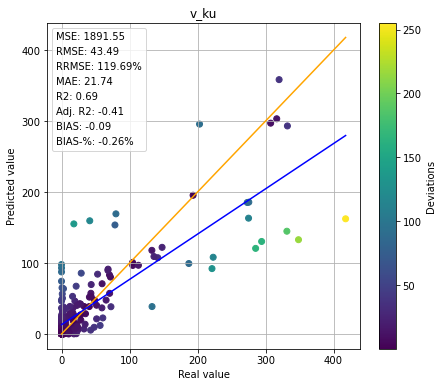

In [12]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)
test_ku_predict = ensemble.get_ensemble_preds(dl=test_dls[0])
reg_itp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])
reg_itp.plot_results(log_y=False)
plt.show()

In [13]:
trainval_tb, test_tb= preprocessor.load_las_image(path='../../data/',
                                                  target_col=['v_lp'],
                                                  log_y=False)

In [14]:
sp_dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())
y_max = trainval_tb.train.y.max()
ensemble = Ensemble(sp_dls, learn_func=tabular_learner,
                    y_range=(0, y_max), 
                    metrics = [rmse, rrmse, bias, bias_pct, mae, R2Score()],
                    n_models=10)

ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,11566.041992,6732.450195,82.051498,377.299927,69.331726,318.810211,75.568542,-3.014728,00:00
1,5679.974609,1425.986328,37.762234,173.643234,-7.581617,-34.862782,16.608702,0.149649,00:00
2,3415.180664,1373.480469,37.060497,170.416412,-9.278163,-42.664059,15.790032,0.180959,00:00
3,2335.717285,1025.085571,32.016956,147.224548,-1.540859,-7.085378,13.559836,0.388716,00:00
4,1666.187012,696.313293,26.387747,121.339584,-0.708080,-3.255986,12.239234,0.584771,00:00
5,1262.139404,1139.582520,33.757702,155.229080,8.039871,36.969986,18.308889,0.320438,00:00
6,987.880737,1162.474487,34.095078,156.780426,-0.077683,-0.357212,14.611858,0.306787,00:00
7,801.344055,1299.663330,36.050846,165.773712,-0.308851,-1.420199,14.491763,0.224978,00:00
8,690.051331,1153.970703,33.970146,156.205963,1.002822,4.611308,13.454792,0.311858,00:00
9,569.768616,1062.380615,32.594181,149.878830,-2.450810,-11.269636,12.082312,0.366476,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,9469.226562,5605.558105,74.870277,344.278290,60.677620,279.015778,68.015099,-2.342735,00:00
1,4610.418457,1043.603760,32.304855,148.548401,-3.460845,-15.914111,15.448564,0.377673,00:00
2,2839.835205,866.606140,29.438175,135.366470,-10.363485,-47.654732,14.131605,0.483221,00:00
3,1971.439941,680.243103,26.081469,119.931221,0.259379,1.192712,13.368840,0.594354,00:00
4,1477.063110,1439.626709,37.942413,174.471756,-11.329402,-52.096336,14.742378,0.141515,00:00
5,1140.221313,1126.116455,33.557659,154.309219,-6.035857,-27.754866,13.084044,0.328469,00:00
6,896.877991,1025.620605,32.025314,147.262985,-0.546016,-2.510764,12.269022,0.388397,00:00
7,713.572144,798.936462,28.265465,129.973953,-5.469196,-25.149172,12.248974,0.523574,00:00
8,575.535522,796.958679,28.230457,129.812973,-1.073824,-4.937797,12.146215,0.524754,00:00
9,480.066925,735.329224,27.116955,124.692726,-4.198540,-19.306276,11.103786,0.561505,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,11172.502930,7043.003418,83.922607,385.903900,71.427475,328.447144,77.740051,-3.199920,00:00
1,5457.571777,1509.994141,38.858646,178.684906,-7.605515,-34.972672,16.547602,0.099553,00:00
2,3323.948486,1007.324219,31.738369,145.943512,-8.123225,-37.353275,14.559475,0.399307,00:00
3,2242.183594,1094.712036,33.086433,152.142365,-0.898861,-4.133258,14.534232,0.347196,00:00
4,1627.808228,882.592102,29.708452,136.609283,-0.927393,-4.264458,13.489720,0.473688,00:00
5,1229.052490,507.101593,22.518915,103.549423,-3.030805,-13.936643,11.716307,0.697603,00:00
6,970.299255,1189.484985,34.488911,158.591415,-7.027590,-32.315186,13.073147,0.290680,00:00
7,771.045898,1072.192261,32.744347,150.569336,-7.329109,-33.701664,13.396139,0.360625,00:00
8,639.617188,695.257996,26.367744,121.247604,-2.835227,-13.037313,11.416393,0.585400,00:00
9,527.784729,1046.849609,32.355057,148.779251,-4.671504,-21.481117,12.480199,0.375737,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,8404.791992,5486.207031,74.068932,340.593445,60.496311,278.182037,67.174896,-2.271563,00:00
1,4080.427002,1262.429688,35.530682,163.381821,-5.530701,-25.431993,15.011450,0.247182,00:00
2,2505.479492,792.773743,28.156239,129.471695,-2.630089,-12.094019,14.911392,0.527249,00:00
3,1738.078491,1072.671997,32.751675,150.603027,6.926708,31.851295,17.084497,0.360339,00:00
4,1286.165161,1104.326782,33.231411,152.809006,-5.539302,-25.471540,13.053229,0.341462,00:00
5,1014.722595,740.340515,27.209196,125.116882,-2.536316,-11.662821,11.505551,0.558516,00:00
6,800.409485,681.539368,26.106310,120.045448,0.920411,4.232354,14.123049,0.593581,00:00
7,648.324219,896.874146,29.947857,137.710144,-2.619664,-12.046082,12.370128,0.465171,00:00
8,549.958130,1068.813599,32.692719,150.331924,0.304967,1.402340,12.588235,0.362640,00:00
9,474.139008,993.533569,31.520369,144.941086,-1.648980,-7.582555,12.107269,0.407531,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,11826.204102,6306.990723,79.416565,365.183624,64.834084,298.128540,72.194344,-2.761017,00:00
1,5831.484863,1637.612183,40.467422,186.082596,-10.643996,-48.944614,18.270121,0.023451,00:00
2,3546.529785,672.511414,25.932825,119.247696,-7.171071,-32.974953,13.910281,0.598965,00:00
3,2400.960449,749.882385,27.383980,125.920593,1.865451,8.577962,15.835558,0.552826,00:00
4,1724.065186,604.309692,24.582714,113.039444,-1.766278,-8.121930,13.432137,0.639635,00:00
5,1280.628052,978.104309,31.274662,143.811234,-6.901307,-31.734489,12.107988,0.416732,00:00
6,981.440735,1070.151978,32.713177,150.426010,-7.600893,-34.951416,13.411716,0.361842,00:00
7,772.078796,703.226318,26.518415,121.940445,1.283316,5.901114,13.056356,0.580649,00:00
8,620.307373,706.392578,26.578045,122.214638,4.033521,18.547462,14.115284,0.578760,00:00
9,510.504822,515.105652,22.695940,104.363441,1.544968,7.104275,12.364137,0.692830,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,8231.561523,4945.493652,70.324203,323.373932,55.877502,256.943207,63.081596,-1.949122,00:00
1,4103.601562,1113.362061,33.367081,153.432877,-6.468132,-29.742611,15.234806,0.336074,00:00
2,2547.400146,739.139404,27.187119,125.015350,-1.910853,-8.786734,14.227426,0.559233,00:00
3,1744.103882,1155.943359,33.999168,156.339417,-3.807324,-17.507336,13.412143,0.310682,00:00
4,1253.612793,837.307007,28.936258,133.058487,5.895433,27.109152,16.092356,0.500693,00:00
5,963.125122,966.708557,31.091940,142.971008,-3.357163,-15.437346,11.716559,0.423527,00:00
6,784.246338,1038.381470,32.223930,148.176285,-6.765033,-31.107859,11.779862,0.380787,00:00
7,650.631165,799.894226,28.282400,130.051834,0.836954,3.848592,13.006404,0.523003,00:00
8,546.475952,983.713928,31.364214,144.223022,-3.268275,-15.028609,11.807828,0.413387,00:00
9,459.947968,636.185791,25.222723,115.982422,-1.494129,-6.870500,11.065067,0.620626,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,9109.855469,5524.499023,74.326973,341.779999,60.950481,280.270477,67.874733,-2.294397,00:00
1,4511.243652,1479.306274,38.461754,176.859863,-9.877357,-45.419350,15.860811,0.117853,00:00
2,2758.894775,1084.018555,32.924438,151.397461,-8.794011,-40.437771,13.869955,0.353573,00:00
3,1864.231201,924.255676,30.401573,139.796478,-0.321237,-1.477155,14.728503,0.448843,00:00
4,1377.442627,1216.270264,34.875065,160.367081,-8.885645,-40.859135,14.598317,0.274708,00:00
5,1073.962646,789.863525,28.104509,129.233826,-0.327524,-1.506062,13.404603,0.528985,00:00
6,832.018127,580.164856,24.086611,110.758194,0.519869,2.390530,12.667737,0.654033,00:00
7,666.434265,581.234680,24.108809,110.860275,1.157609,5.323068,12.806705,0.653395,00:00
8,558.563782,1133.497314,33.667454,154.814087,-6.301818,-28.977844,12.745234,0.324067,00:00
9,485.835419,871.753418,29.525471,135.767883,-3.103256,-14.269795,12.569540,0.480152,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,8088.220703,5152.497559,71.780899,330.072296,57.592453,264.829132,64.895439,-2.072563,00:00
1,3930.556641,1232.033081,35.100330,161.402924,-4.899852,-22.531141,15.736292,0.265308,00:00
2,2413.645508,631.050476,25.120718,115.513374,-3.837503,-17.646109,13.582798,0.623689,00:00
3,1703.971558,1027.722046,32.058105,147.413773,9.152688,42.087086,17.226376,0.387144,00:00
4,1299.383789,1038.190674,32.220966,148.162659,-0.199889,-0.919158,13.308198,0.380901,00:00
5,1020.867920,1065.926147,32.648525,150.128708,4.435764,20.397108,15.632769,0.364362,00:00
6,814.064514,948.385376,30.795868,141.609589,-0.456239,-2.097939,13.076690,0.434454,00:00
7,668.089722,945.047913,30.741632,141.360184,-5.151962,-23.690424,12.453010,0.436444,00:00
8,567.282349,631.243164,25.124552,115.530991,-2.816667,-12.951967,11.608872,0.623574,00:00
9,470.214111,723.219421,26.892738,123.661697,-1.481150,-6.810818,11.472678,0.568726,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,15737.359375,9922.250977,99.610497,458.041992,89.934753,413.549744,94.942680,-4.916886,00:00
1,7878.029297,1641.838623,40.519608,186.322556,-8.006451,-36.816307,19.132847,0.020930,00:00
2,4746.293457,1283.820557,35.830441,164.760208,-10.230991,-47.045479,16.764162,0.234426,00:00
3,3164.251465,1110.581299,33.325386,153.241150,-7.160086,-32.924438,13.598914,0.337733,00:00
4,2221.727539,533.480957,23.097206,106.208588,-0.625623,-2.876822,12.057843,0.681872,00:00
5,1624.090088,786.958801,28.052788,128.995987,-2.307090,-10.608762,12.085304,0.530717,00:00
6,1225.945312,822.165527,28.673428,131.849899,-5.587233,-25.691942,12.634471,0.509722,00:00
7,956.640991,804.172241,28.357929,130.399139,-1.493442,-6.867340,11.841979,0.520452,00:00
8,750.210693,589.618469,24.282061,111.656937,-2.202995,-10.130101,11.518430,0.648396,00:00
9,611.675781,619.519531,24.890150,114.453140,0.951495,4.375289,11.992216,0.630565,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,9537.625977,5800.147949,76.158699,350.202881,62.527069,287.520142,69.200546,-2.458774,00:00
1,4715.199707,1423.081055,37.723751,173.466278,-6.055246,-27.844027,16.195503,0.151381,00:00
2,2857.853027,888.237244,29.803308,137.045471,-3.153350,-14.500147,14.722935,0.470322,00:00
3,1955.551025,1128.558716,33.594028,154.476456,-5.011080,-23.042604,13.337057,0.327012,00:00
4,1414.672607,1118.847656,33.449181,153.810394,-1.655527,-7.612659,13.099644,0.332803,00:00
5,1077.444702,850.914734,29.170443,134.135345,-0.083933,-0.385951,13.129751,0.492578,00:00
6,830.257141,1100.535889,33.174324,152.546509,0.866871,3.986161,12.921702,0.343723,00:00
7,665.059692,1278.460327,35.755562,164.415894,-8.699587,-40.003578,13.116390,0.237622,00:00
8,568.032104,1086.079224,32.955715,151.541275,-0.526780,-2.422308,12.939971,0.352344,00:00
9,480.122925,1091.530151,33.038311,151.921082,-3.258902,-14.985509,12.484912,0.349093,00:00


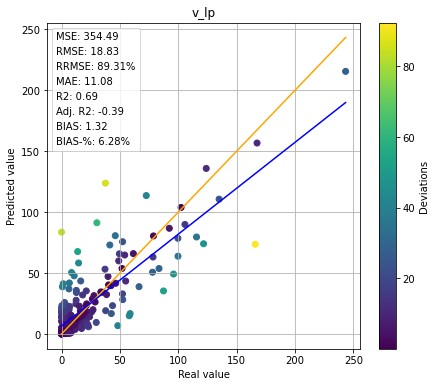

In [15]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)
test_lp_predict = ensemble.get_ensemble_preds(dl=test_dls[0])
reg_itp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])
reg_itp.plot_results(log_y=False)
plt.show()

# Scale all predictions to percentages

In [16]:
scaled_ma = test_ma_predict[1] / (test_ma_predict[1] + test_ku_predict[1] + test_lp_predict[1])
scaled_ku = test_ku_predict[1] / (test_ma_predict[1] + test_ku_predict[1] + test_lp_predict[1])
scaled_lp = test_lp_predict[1] / (test_ma_predict[1] + test_ku_predict[1] + test_lp_predict[1])

In [17]:
pred_v_ma = test_v_predict[1] * scaled_ma
pred_v_ku = test_v_predict[1] * scaled_ku
pred_v_lp = test_v_predict[1] * scaled_lp

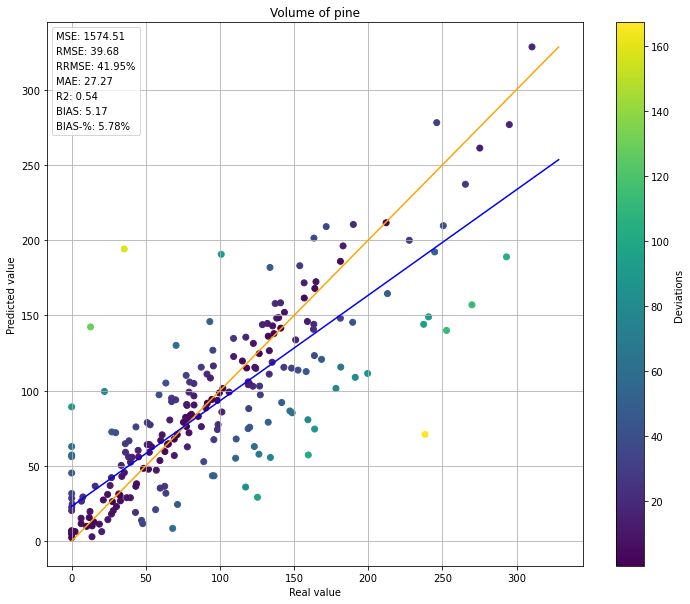

In [18]:
import matplotlib.patches as mpl_patches

fig, a = plt.subplots(1,1, figsize=(12,10))
im = a.scatter(test_ma_predict[2][:,0], pred_v_ma[:,0], c=np.abs(test_ma_predict[2][:,0]-pred_v_ma[:,0]))
a.set_xlabel('Real value')
a.set_ylabel('Predicted value')
a.set_title('Volume of pine')
a.grid()
x = np.linspace(0, max(pred_v_ma[:,0].max(),test_ma_predict[2][:,0].max()))
a.plot(x, x, color='orange')
m, b = np.polyfit(test_ma_predict[2][:,0], pred_v_ma[:,0], 1)
a.plot(x, m*x+b, color='blue')
cbar = plt.colorbar(im, ax=a)
cbar.ax.set_ylabel('Deviations', rotation=90)
res_mae = mae(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
res_mse = mse(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
res_rmse = rmse(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
res_rrmse = res_rmse / test_ma_predict[2].mean() * 100
r2 = R2Score()(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
res_bias = bias(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
res_pct_bias = bias_pct(Tensor(test_ma_predict[2][:,0]), Tensor(pred_v_ma[:,0]))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
           lw=0, alpha=0)] * 8
labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
          f'MAE: {res_mae:.2f}', f'R2: {r2:.2f}', #f'Adj. R2: {adjusted_r2:.2f}',
          f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
plt.show()

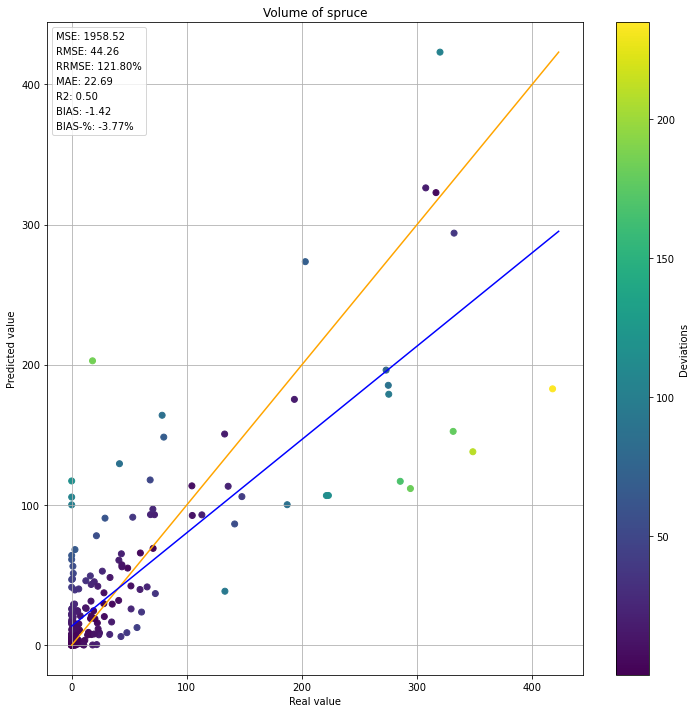

In [19]:

fig, a = plt.subplots(1,1, figsize=(12,12))
im = a.scatter(test_ku_predict[2][:,0], pred_v_ku[:,0], c=np.abs(test_ku_predict[2][:,0]-pred_v_ku[:,0]))
a.set_xlabel('Real value')
a.set_ylabel('Predicted value')
a.set_title('Volume of spruce')
a.grid()
x = np.linspace(0, max(pred_v_ku[:,0].max(),test_ku_predict[2][:,0].max()))
a.plot(x, x, color='orange')
m, b = np.polyfit(test_ku_predict[2][:,0], pred_v_ku[:,0], 1)
a.plot(x, m*x+b, color='blue')
cbar = plt.colorbar(im, ax=a)
cbar.ax.set_ylabel('Deviations', rotation=90)
res_kue = mae(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_mse = mse(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_rmse = rmse(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_rrmse = res_rmse / test_ku_predict[2].mean() * 100
r2 = R2Score()(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_bias = bias(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_pct_bias = bias_pct(Tensor(test_ku_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
           lw=0, alpha=0)] * 8
labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
          f'MAE: {res_kue:.2f}', f'R2: {r2:.2f}', #f'Adj. R2: {adjusted_r2:.2f}',
          f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
plt.show()

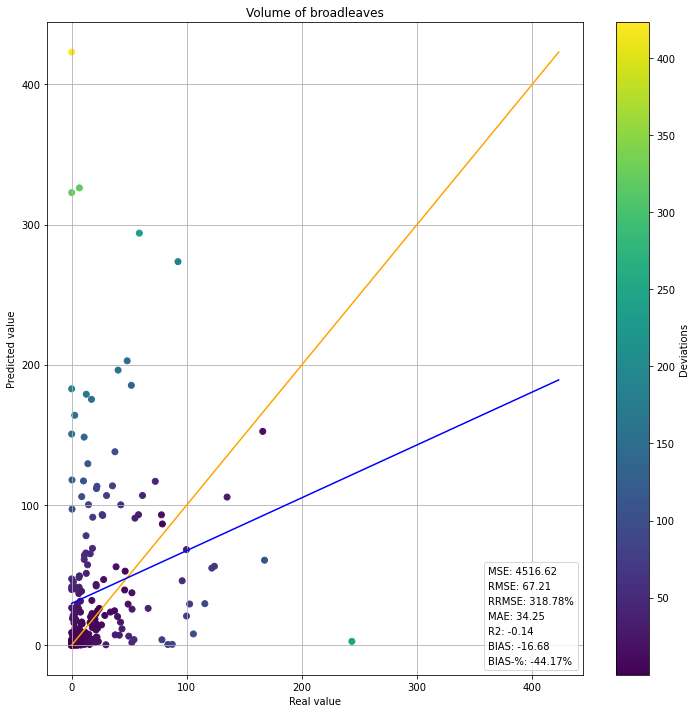

In [20]:

fig, a = plt.subplots(1,1, figsize=(12,12))
im = a.scatter(test_lp_predict[2][:,0], pred_v_ku[:,0], c=np.abs(test_lp_predict[2][:,0]-pred_v_ku[:,0]))
a.set_xlabel('Real value')
a.set_ylabel('Predicted value')
a.set_title('Volume of broadleaves')
a.grid()
x = np.linspace(0, max(pred_v_ku[:,0].max(),test_lp_predict[2][:,0].max()))
a.plot(x, x, color='orange')
m, b = np.polyfit(test_lp_predict[2][:,0], pred_v_ku[:,0], 1)
a.plot(x, m*x+b, color='blue')
cbar = plt.colorbar(im, ax=a)
cbar.ax.set_ylabel('Deviations', rotation=90)
res_kue = mae(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_mse = mse(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_rmse = rmse(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_rrmse = res_rmse / test_lp_predict[2].mean() * 100
r2 = R2Score()(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_bias = bias(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
res_pct_bias = bias_pct(Tensor(test_lp_predict[2][:,0]), Tensor(pred_v_ku[:,0]))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
           lw=0, alpha=0)] * 8
labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
          f'MAE: {res_kue:.2f}', f'R2: {r2:.2f}', #f'Adj. R2: {adjusted_r2:.2f}',
          f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
plt.show()

In [21]:
sum_v = test_ma_predict[1] + test_ku_predict[1] + test_lp_predict[1]

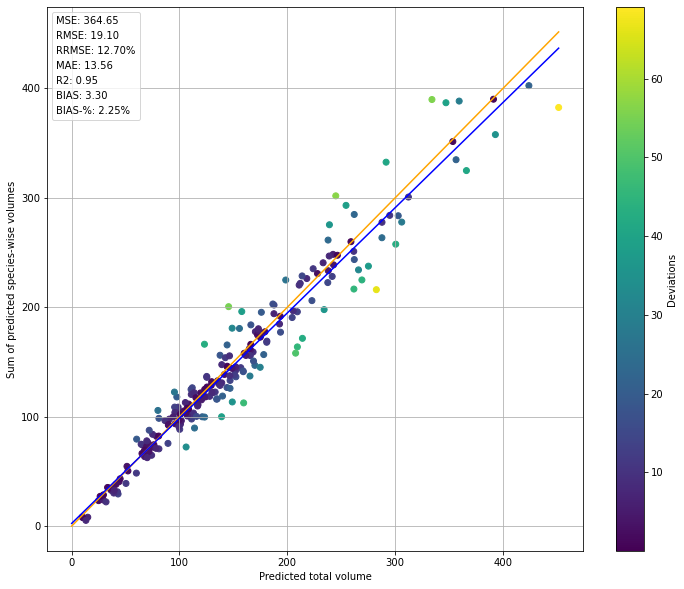

In [22]:

fig, a = plt.subplots(1,1, figsize=(12,10))
im = a.scatter(test_v_predict[1][:,0], sum_v[:,0], c=np.abs(test_v_predict[1][:,0]-sum_v[:,0]))
a.set_xlabel('Predicted total volume')
a.set_ylabel('Sum of predicted species-wise volumes')
a.grid()
x = np.linspace(0, max(sum_v[:,0].max(),test_v_predict[1][:,0].max()))
a.plot(x, x, color='orange')
m, b = np.polyfit(test_v_predict[1][:,0], sum_v[:,0], 1)
a.plot(x, m*x+b, color='blue')
cbar = plt.colorbar(im, ax=a)
cbar.ax.set_ylabel('Deviations', rotation=90)
res_kue = mae(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
res_mse = mse(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
res_rmse = rmse(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
res_rrmse = res_rmse / test_v_predict[1].mean() * 100
r2 = R2Score()(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
res_bias = bias(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
res_pct_bias = bias_pct(Tensor(test_v_predict[1][:,0]), Tensor(sum_v[:,0]))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
           lw=0, alpha=0)] * 8
labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
          f'MAE: {res_kue:.2f}', f'R2: {r2:.2f}', #f'Adj. R2: {adjusted_r2:.2f}',
          f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
plt.show()

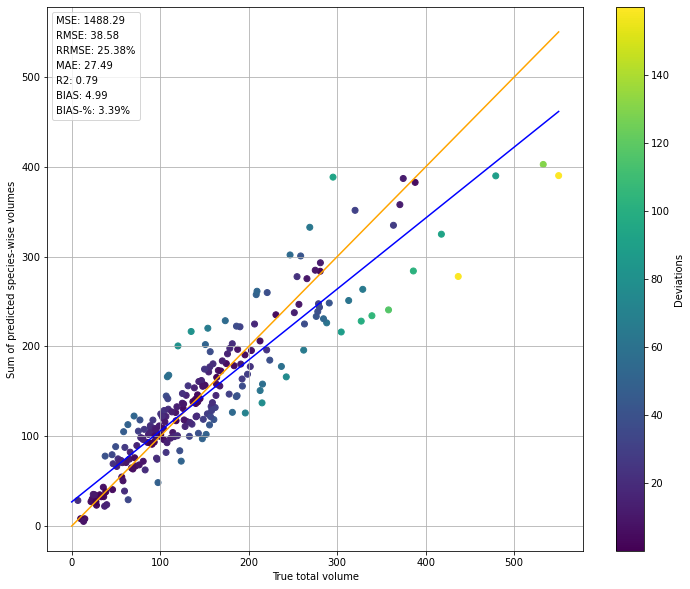

In [23]:
fig, a = plt.subplots(1,1, figsize=(12,10))
im = a.scatter(test_v_predict[2][:,0], sum_v[:,0], c=np.abs(test_v_predict[2][:,0]-sum_v[:,0]))
a.set_xlabel('True total volume')
a.set_ylabel('Sum of predicted species-wise volumes')
a.grid()
x = np.linspace(0, max(sum_v[:,0].max(),test_v_predict[2][:,0].max()))
a.plot(x, x, color='orange')
m, b = np.polyfit(test_v_predict[2][:,0], sum_v[:,0], 1)
a.plot(x, m*x+b, color='blue')
cbar = plt.colorbar(im, ax=a)
cbar.ax.set_ylabel('Deviations', rotation=90)
res_kue = mae(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
res_mse = mse(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
res_rmse = rmse(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
res_rrmse = res_rmse / test_v_predict[2].mean() * 100
r2 = R2Score()(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
res_bias = bias(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
res_pct_bias = bias_pct(Tensor(test_v_predict[2][:,0]), Tensor(sum_v[:,0]))
handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
           lw=0, alpha=0)] * 8
labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
          f'MAE: {res_kue:.2f}', f'R2: {r2:.2f}', #f'Adj. R2: {adjusted_r2:.2f}',
          f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
plt.show()